In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import array
import math
import pandas as pd
#from astropy.cosmology import FlatLambdaCDM
import matplotlib
from matplotlib import gridspec

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
# create a new FlatLambdaCDM object with arguments giving the Hubble parameter and Omega matter (both at z=0)
#cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [ ]:
out_dir = '../out/pantheon'

In [37]:
data_dir = '../data/Pantheon/data_fitres/Ancillary_C11.FITRES'

data = (np.genfromtxt(
    data_dir,
    skip_header=6, 
    names=True,
    comments='#')
)

data = pd.DataFrame(data)

data = data.sort_values('zCMB')

In [38]:
data

,VARNAMES,CID,CIDint,IDSURVEY,TYPE,FIELD,CUTFLAG_SNANA,zCMB,zCMBERR,zHD,...,MURES,MUPULL,ERRCODE,biasCor_mu,biasCorErr_mu,biasCor_mB,biasCor_x1,biasCor_c,biasScale_muCOV,IDSAMPLE
677,NaN,NaN,169.0,65.0,1.0,NaN,1.0,0.00931,0.0000,0.01043,...,0.010,0.052,0.0,-0.040,0.005,0.008,-0.007,0.013,0.820,0.0
583,NaN,NaN,17.0,63.0,0.0,NaN,1.0,0.01025,0.0000,0.01012,...,0.062,0.324,0.0,0.006,0.005,-0.005,-0.005,-0.003,0.747,0.0
702,NaN,NaN,202.0,5.0,1.0,NaN,1.0,0.01042,0.0000,0.01082,...,0.007,0.040,0.0,0.070,0.004,-0.021,-0.018,-0.026,0.690,0.0
585,NaN,NaN,21.0,63.0,0.0,NaN,1.0,0.01045,0.0000,0.01038,...,0.137,0.662,0.0,-0.054,0.008,0.013,-0.010,0.018,0.873,0.0
688,NaN,NaN,181.0,66.0,1.0,NaN,1.0,0.01123,0.0000,0.01226,...,0.199,1.150,0.0,0.022,0.008,-0.009,-0.066,-0.011,0.725,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,NaN,NaN,6.0,106.0,-9.0,NaN,1.0,1.55000,0.0001,1.55000,...,0.172,0.904,0.0,0.331,0.011,-0.046,-0.407,-0.119,0.530,4.0
1026,NaN,NaN,7.0,106.0,-9.0,NaN,1.0,1.70000,0.0400,1.70000,...,-0.024,-0.085,0.0,0.321,0.012,-0.018,0.426,-0.074,0.522,4.0
1027,NaN,NaN,8.0,106.0,0.0,NaN,1.0,1.80000,0.0200,1.80000,...,-0.005,-0.027,0.0,-0.178,0.011,-0.043,-0.287,0.024,0.487,4.0
1029,NaN,NaN,10.0,106.0,0.0,NaN,1.0,1.91400,0.0010,1.91400,...,-0.223,-0.835,0.0,-0.477,0.025,-0.047,-0.661,0.089,0.403,4.0


In [39]:
z = data['zCMB'].astype(float)
mu = data['MU'].astype(float)
mu_err = data['MUERR'].astype(float)
idsurvey = data['IDSURVEY'].astype(float) 

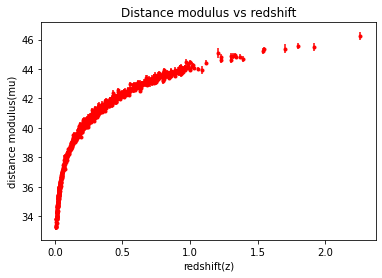

In [40]:
plt.errorbar(z, mu, yerr=mu_err, fmt='.r');
plt.xlabel('redshift(z)')
plt.ylabel('distance modulus(mu)')
plt.title('Distance modulus vs redshift')
plt.show()

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
z_train, z_val, mu_train, mu_val = train_test_split(z, mu, test_size=0.2, random_state=0)

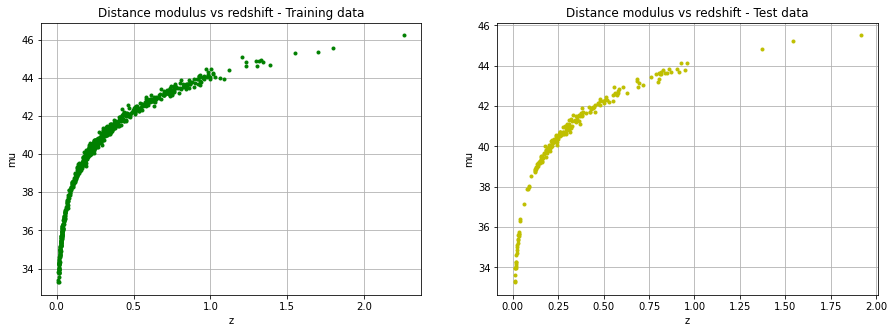

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(z_train, mu_train, '.g')
ax1.set_ylabel('mu')
ax1.set_xlabel('z')
ax1.set_title('Distance modulus vs redshift - Training data')
ax1.grid(True)

ax2.plot(z_val, mu_val, '.y')
ax2.set_ylabel('mu')
ax2.set_xlabel('z')
ax2.set_title('Distance modulus vs redshift - Test data')
ax2.grid(True)

plt.show()

In [66]:
# prepare sequential data
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

In [67]:
window_size = 4
train_stride = 1

z_strided = strided_app(z.to_numpy(), window_size, train_stride)
mu_strided = strided_app(mu.to_numpy(), window_size, train_stride)

z_train, z_val, mu_train, mu_val = train_test_split(z_strided, mu_strided, test_size=0.2, random_state=0)

In [68]:
z_train = np.expand_dims(z_train, axis=-1)
#z_test = np.expand_dims(z_test, axis=-1)
z_val = np.expand_dims(z_val, axis=-1)
mu_train = np.expand_dims(mu_train, axis=-1)
#mu_test = np.expand_dims(mu_test, axis=-1)
mu_val = np.expand_dims(mu_val, axis=-1)